In [1]:
#pip install mysql-connector-python

In [1]:
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import os
import warnings


# Load environment variables
_ = load_dotenv()

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Configuration to suppress warnings
warnings.filterwarnings('ignore')

# Additional configurations for better control over visualizations (optional)
plt.style.use('ggplot')  # For ggplot-like style in plots
pd.options.display.max_columns = None  # Ensure all columns are visible when displaying DataFrames


In [3]:
import matplotlib.dates as mdates
import plotly.express as px



In [4]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

## Load the Dateset

In [5]:
# Define the path to the dataset
file_path = 'RAW_Data/main_data.csv'

# Load the dataset
df = pd.read_csv(file_path)

In [6]:
df.isnull().sum()

Unnamed: 0       0
time             0
low              0
high             0
open             0
close            0
volume           0
price_change     0
average_price    0
volatitlity      0
product_id       0
dtype: int64

In [7]:
# Display the first few rows of the dataframe and the counts of unique product IDs
print("First few rows of the dataset:")
print(df.head())
print("\nCount of unique product IDs:")
print(df['product_id'].value_counts())

First few rows of the dataset:
   Unnamed: 0        time       low      high      open     close  \
0           0  2022-01-14  41752.00  43473.98  42576.27  43090.72   
1           1  2022-01-13  42325.00  44453.22  43921.21  42581.65   
2           2  2022-01-12  42459.21  44342.83  42749.84  43920.37   
3           3  2022-01-11  41274.80  43130.00  41824.06  42753.44   
4           4  2022-01-10  39650.00  42250.00  41876.52  41824.07   

         volume  price_change  average_price  volatitlity product_id  
0  13545.750865        514.45       42612.99     4.124305    BTC-USD  
1  14772.094786      -1339.56       43389.11     5.028281    BTC-USD  
2  16250.214697       1170.53       43401.02     4.436305    BTC-USD  
3  19697.466133        929.38       42202.40     4.494752    BTC-USD  
4  25232.357396        -52.45       40950.00     6.557377    BTC-USD  

Count of unique product IDs:
product_id
BTC-USD     1084
ETH-USD     1084
SOL-USD     1084
ADA-USD     1084
LINK-USD    1084
LT

## Intitial Cleaning, Data Interpolation and Frequency Setting

In [7]:
# Remove the 'Unnamed: 0' column as it's redundant
df.drop(columns=['Unnamed: 0'], inplace=True)

# Convert 'time' column to datetime format
df['time'] = pd.to_datetime(df['time'])

# Sort the DataFrame by the 'time' column
df.sort_values(by='time', ascending=True, inplace=True)

# Set 'time' as the index of the DataFrame
df.set_index('time', inplace=True)

# Remove duplicate indices
# df = df[~df.index.duplicated(keep='first')]

# Ensure continuous daily frequency and interpolate missing values based on time
#df = df.asfreq('D').interpolate(method='time')

# Calculate daily percentage change in 'close' price
df['pct_change'] = df['close'].pct_change() * 100  # multiply by 100 to convert to percentage

# Print the updated DataFrame to verify changes
print("Updated DataFrame with Daily Frequency and Interpolated Values:")
print(df.head())


Updated DataFrame with Daily Frequency and Interpolated Values:
                    low         high         open        close        volume  \
time                                                                           
2021-07-15     28.00000     31.50000     31.33000     28.59400  4.882208e+05   
2021-07-15     15.51165     17.23657     16.92966     15.76518  2.550619e+06   
2021-07-15   1880.00000   2039.99000   1994.12000   1918.07000  2.294777e+05   
2021-07-15      1.20510      1.29000      1.26360      1.22490  3.205589e+07   
2021-07-15  31064.77000  33187.60000  32815.75000  31868.68000  1.127361e+04   

            price_change  average_price  volatitlity product_id    pct_change  
time                                                                           
2021-07-15      -2.73600       29.75000    12.500000    SOL-USD           NaN  
2021-07-15      -1.16448       16.37411    11.120158   LINK-USD -4.486543e+01  
2021-07-15     -76.05000     1959.99500     8.510106   

In [8]:
df.head()

low         high         open        close        volume  \
time                                                                           
2021-07-15     28.00000     31.50000     31.33000     28.59400  4.882208e+05   
2021-07-15     15.51165     17.23657     16.92966     15.76518  2.550619e+06   
2021-07-15   1880.00000   2039.99000   1994.12000   1918.07000  2.294777e+05   
2021-07-15      1.20510      1.29000      1.26360      1.22490  3.205589e+07   
2021-07-15  31064.77000  33187.60000  32815.75000  31868.68000  1.127361e+04   

            price_change  average_price  volatitlity product_id    pct_change  
time                                                                           
2021-07-15      -2.73600       29.75000    12.500000    SOL-USD           NaN  
2021-07-15      -1.16448       16.37411    11.120158   LINK-USD -4.486543e+01  
2021-07-15     -76.05000     1959.99500     8.510106    ETH-USD  1.206650e+04  
2021-07-15      -0.03870        1.24755     7.045059    ADA-USD -9.993614e+01  
2021-07-15    -947.07000    32126.18500     6.833561    BTC-USD  2.601637e+06

### Summary Statistics

In [ ]:
# Identify numeric columns for statistical analysis
numeric_cols = df.select_dtypes(include=[np.number])  # This selects all the columns that are of numeric type

# Group by 'product_id' and calculate basic statistics for numeric columns
grouped_stats = df.groupby('product_id')[numeric_cols.columns].agg(['mean', 'std', 'min', 'max'])

# Calculate skewness and kurtosis separately using apply() for compatibility
skewness = df.groupby('product_id')[numeric_cols.columns].apply(lambda x: x.skew()).rename(columns=lambda x: x + '_skew')
kurtosis = df.groupby('product_id')[numeric_cols.columns].apply(lambda x: x.kurt()).rename(columns=lambda x: x + '_kurtosis')

# Concatenate the skewness and kurtosis DataFrames to the grouped_stats DataFrame
detailed_stats = pd.concat([grouped_stats, skewness, kurtosis], axis=1)

print("\nDetailed Summary Statistics by Cryptocurrency:")
print(detailed_stats)



Detailed Summary Statistics by Cryptocurrency:
             (low, mean)    (low, std)  (low, min)  (low, max)  (high, mean)  \
product_id                                                                     
ADA-USD         0.676804      0.537305      0.2368      2.8031      0.725698   
BTC-USD     36655.065871  15594.314063  15512.0000  70093.9800  38237.674129   
ETH-USD      2247.921276    840.266075   1012.7200   4423.0100   2376.936071   
LINK-USD       13.216273      7.443585      5.0000     33.4000     14.309512   
LTC-USD        89.345974     38.840486     44.3600    223.1300     95.671688   
SOL-USD        67.632706     54.401112      8.0000    240.5830     73.966969   
XRP-USD         0.561828      0.075944      0.4310      0.7669      0.595546   

             (high, std)  (high, min)  (high, max)  (open, mean)  \
product_id                                                         
ADA-USD         0.582251       0.2461      2.93030      0.703280   
BTC-USD     16262.645907   

The detailed statistical summary highlights significant differences in price behaviors across various cryptocurrencies. For example, Bitcoin and Ethereum show high price ranges and volatilities, reflecting their established status and active market participation. This suggests that these cryptocurrencies respond strongly to market dynamics, making them central to risk assessment and investment strategies. In contrast, smaller cryptocurrencies like ADA and XRP, while less volatile, exhibit noticeable fluctuations that cannot be overlooked, as they can impact short-term trading and speculative opportunities.

### EDA

#### Time Series Visualization with Trend Lines

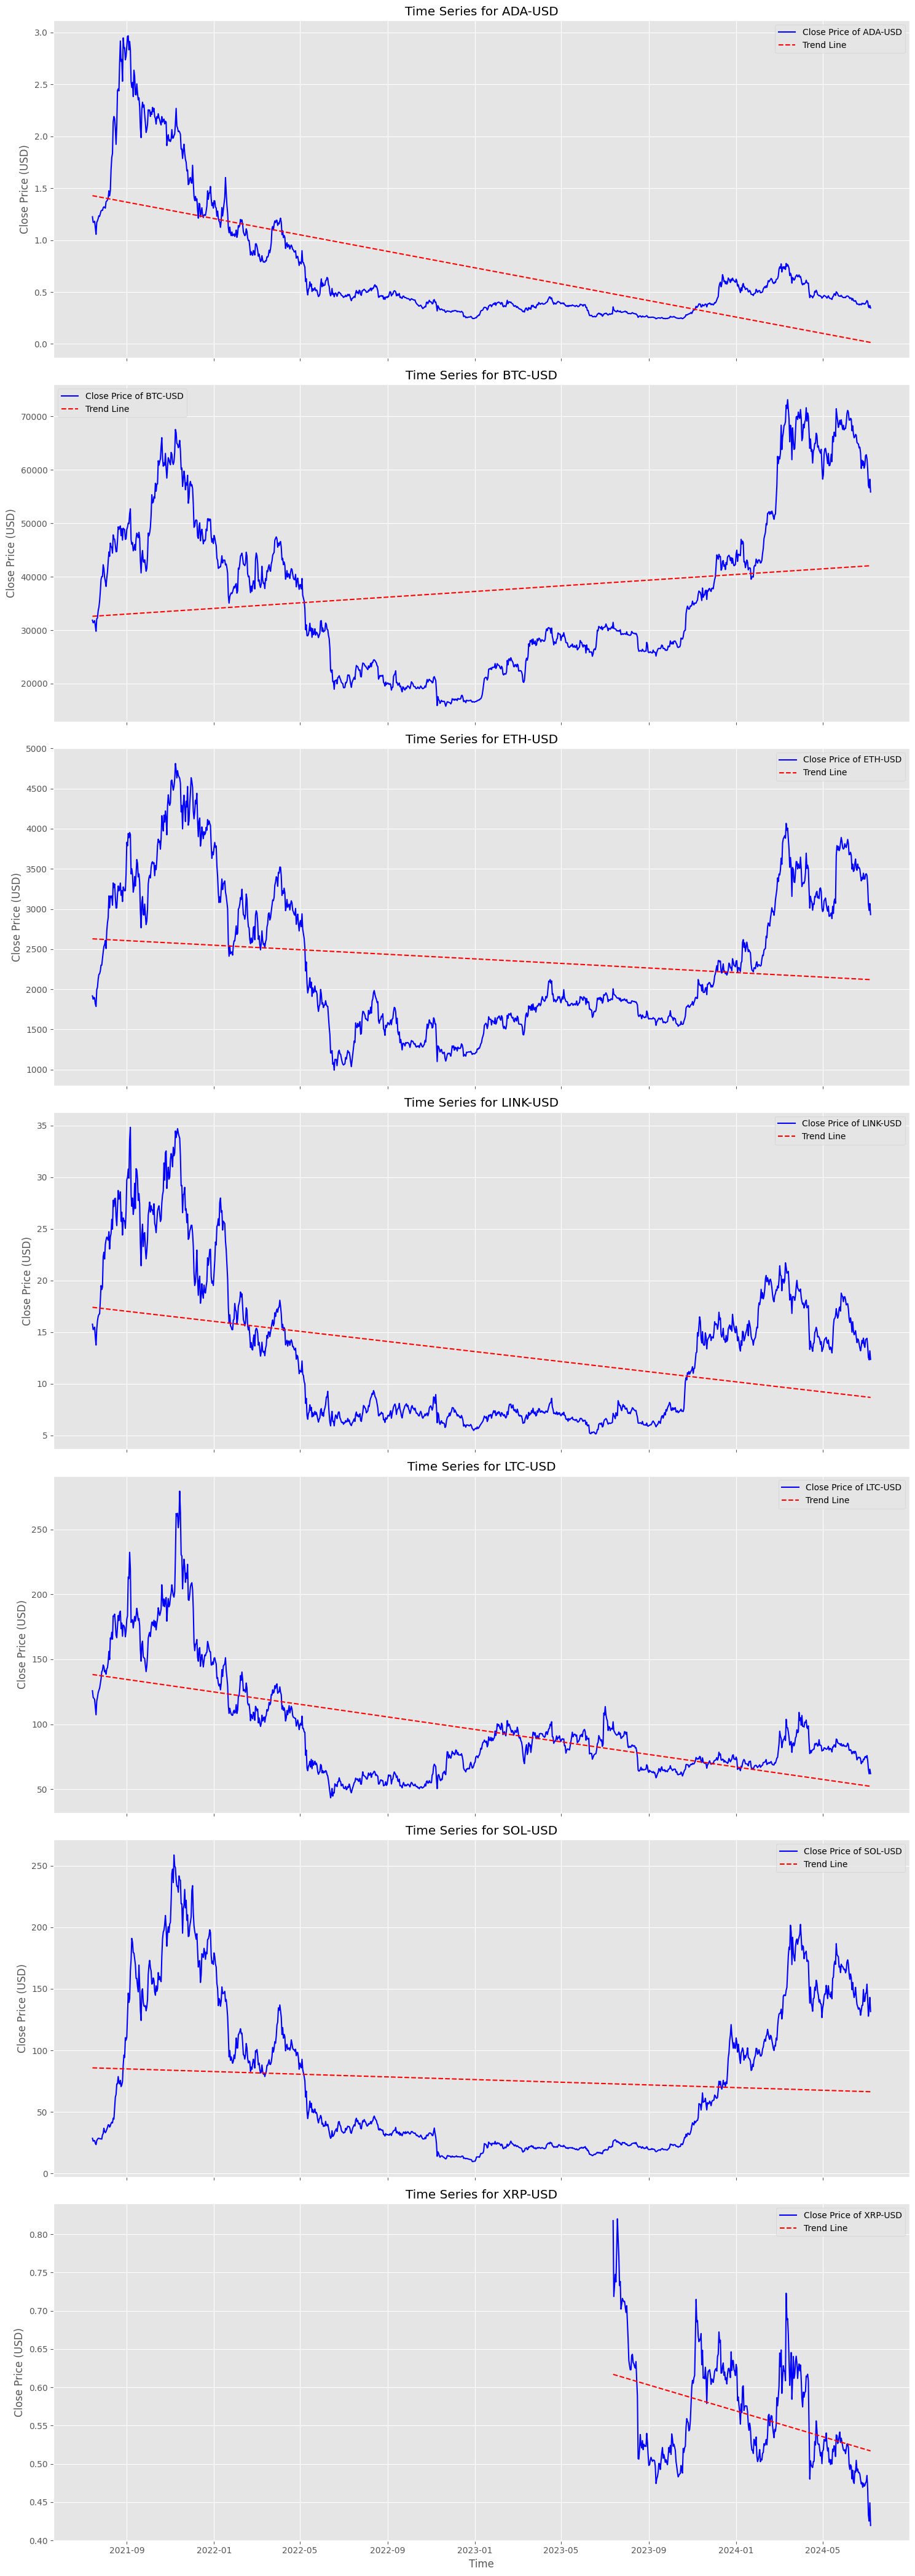

In [9]:
# Set the figure size and subplots
fig, axs = plt.subplots(len(df['product_id'].unique()), figsize=(15, 6 * len(df['product_id'].unique())), sharex=True)

# Iterate over each unique cryptocurrency for plotting
for i, (label, df_product) in enumerate(df.groupby('product_id')):
    axs[i].plot(df_product.index, df_product['close'], label=f'Close Price of {label}', color='blue')
    # Adding a trend line
    z = np.polyfit(mdates.date2num(df_product.index), df_product['close'], 1)
    p = np.poly1d(z)
    axs[i].plot(df_product.index, p(mdates.date2num(df_product.index)), "r--", label="Trend Line")
    axs[i].set_title(f'Time Series for {label}')
    axs[i].set_ylabel('Close Price (USD)')
    axs[i].legend()

plt.xlabel('Time')
plt.tight_layout()
plt.show()

This segment creates a subplot for each cryptocurrency with its close prices over time, enhanced with trend lines to easily visualize the overall direction of price movements.

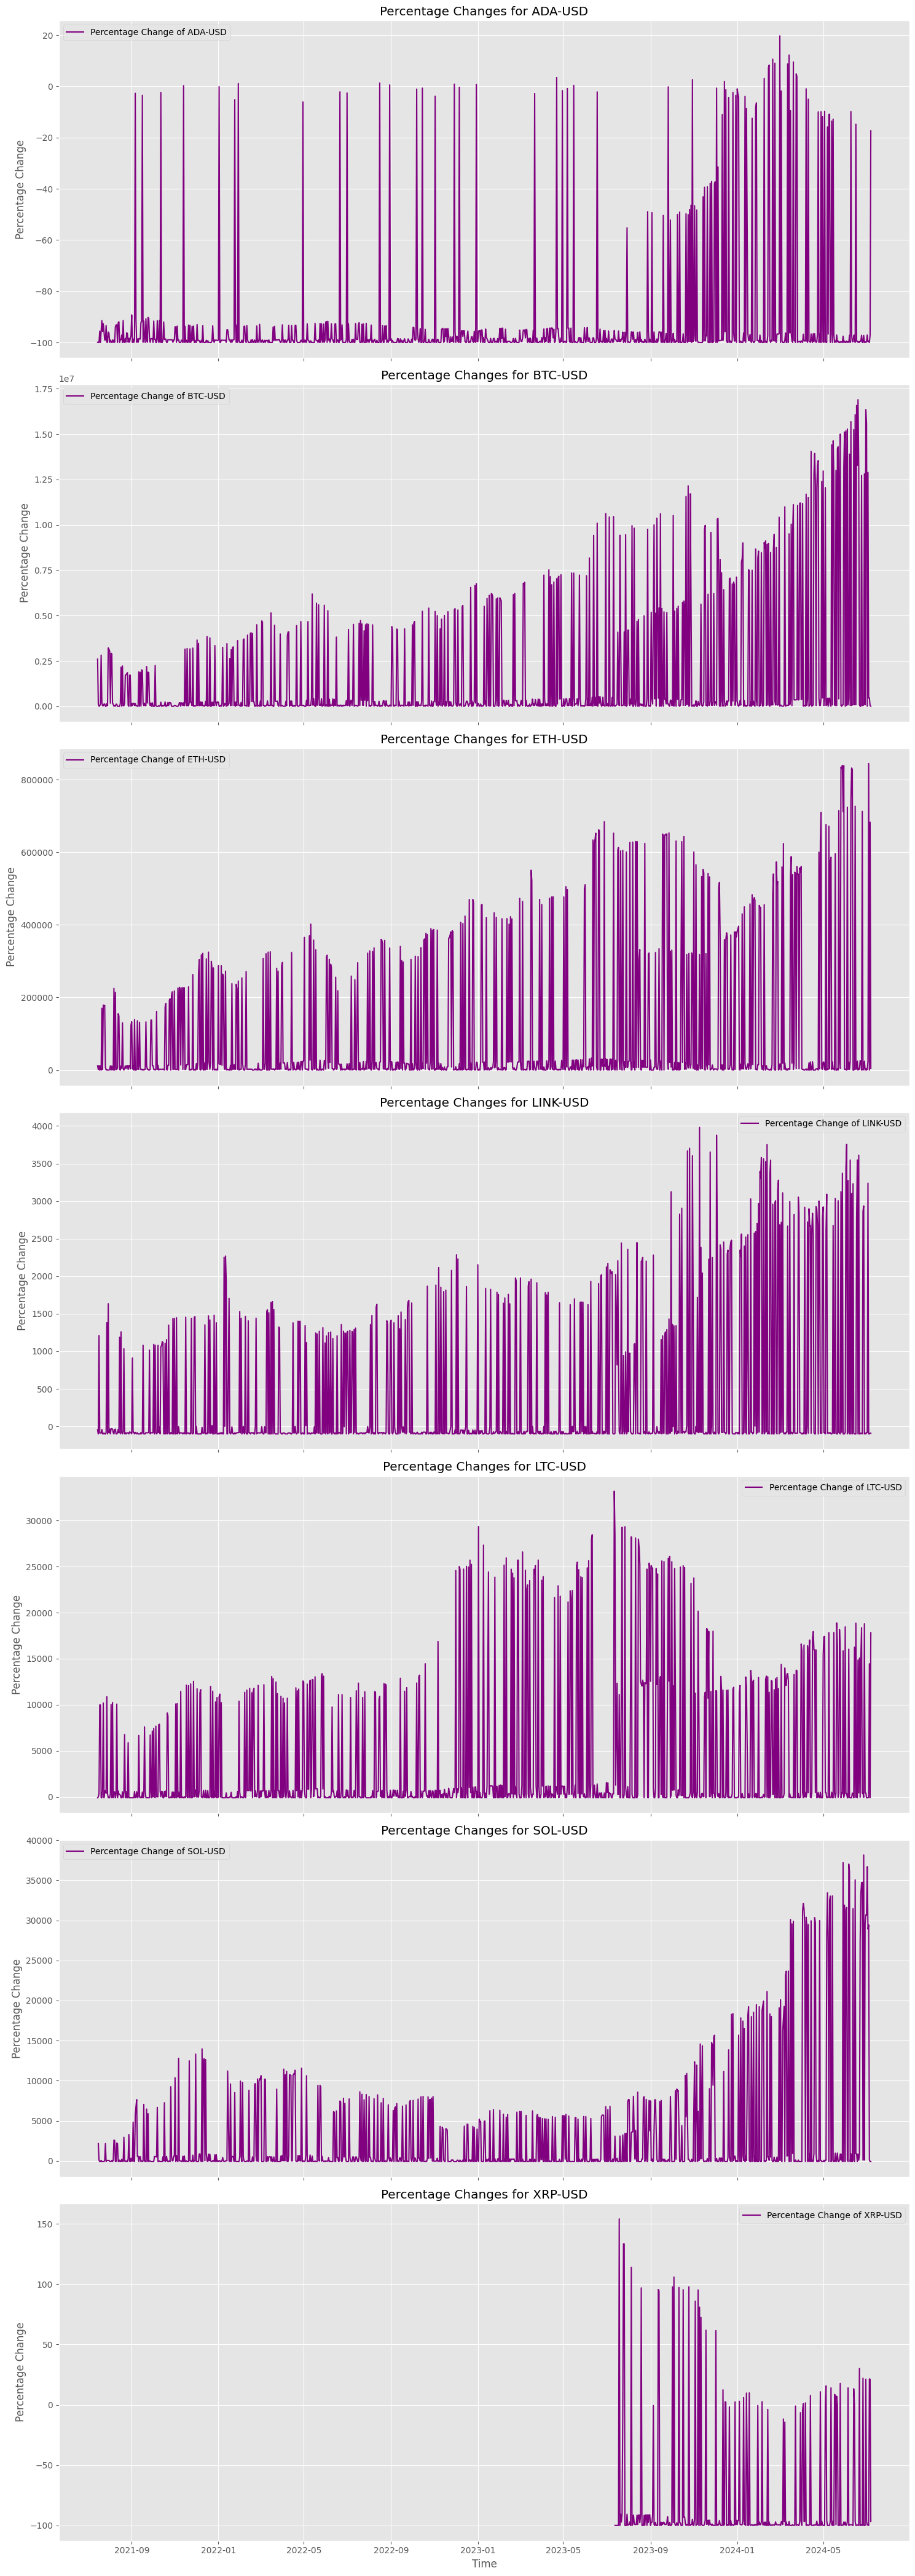

In [10]:
# Time Series of Percentage Changes for Each Cryptocurrency
fig, axs = plt.subplots(len(df['product_id'].unique()), figsize=(15, 6 * len(df['product_id'].unique())), sharex=True)

for i, (label, df_product) in enumerate(df.groupby('product_id')):
    axs[i].plot(df_product.index, df_product['pct_change'], label=f'Percentage Change of {label}', color='purple')
    axs[i].set_title(f'Percentage Changes for {label}')
    axs[i].set_ylabel('Percentage Change')
    axs[i].legend()

plt.xlabel('Time')
plt.tight_layout()
plt.show()


#### Interactive Time Series Visualization using Plotly

In [ ]:
# Combine all product data into one DataFrame for easier plotting
fig = px.line(df.reset_index(), x='time', y='close', color='product_id', title='Interactive Time Series of Close Prices',
              labels={'close': 'Close Price (USD)', 'time': 'Time', 'product_id': 'Cryptocurrency'})
fig.update_xaxes(rangeslider_visible=True)
fig.show()


This provides an interactive plot where you can zoom in and out dynamically. The range slider allows for examining specific time frames, which is beneficial for identifying localized patterns or anomalies.

In [ ]:
# Reset the index to use 'time' as a column in Plotly
df_reset = df.reset_index()

# Create an interactive line plot for percentage changes
fig_pct_change = px.line(df_reset, x='time', y='pct_change', color='product_id', 
                         title='Interactive Time Series of Percentage Changes',
                         labels={'pct_change': 'Percentage Change', 'time': 'Time', 'product_id': 'Cryptocurrency'})
fig_pct_change.update_xaxes(rangeslider_visible=True)
fig_pct_change.show()

## Data Cleaning & Feature Engineering

In [11]:
# Print the column names of the DataFrame
print(df.columns)


Index(['low', 'high', 'open', 'close', 'volume', 'price_change',
       'average_price', 'volatitlity', 'product_id', 'pct_change'],
      dtype='object')


In [12]:
# Print the DataFrame's index to check if 'time' is the index
print(df.index)


DatetimeIndex(['2021-07-15', '2021-07-15', '2021-07-15', '2021-07-15',
               '2021-07-15', '2021-07-15', '2021-07-16', '2021-07-16',
               '2021-07-16', '2021-07-16',
               ...
               '2024-07-06', '2024-07-06', '2024-07-06', '2024-07-07',
               '2024-07-07', '2024-07-07', '2024-07-07', '2024-07-07',
               '2024-07-07', '2024-07-07'],
              dtype='datetime64[ns]', name='time', length=6863, freq=None)


In [15]:
# Calculate daily percentage change in 'close' price
df['pct_change'] = df['close'].pct_change() * 100  # multiply by 100 to convert to percentage

# Adding lag features for close prices and volume
for lag in [1, 3, 7]:  # Example lags: previous day, 3 days ago, and a week ago
    df[f'close_lag_{lag}'] = df['close'].shift(lag)
    df[f'volume_lag_{lag}'] = df['volume'].shift(lag)

# Calculate Moving Average (MA)
df['close_MA10'] = df['close'].rolling(window=10).mean()

# Calculate Exponential Moving Average (EMA) for different periods
for window in [7, 14, 30]:
    df[f'close_ema_{window}'] = df['close'].ewm(span=window, adjust=False).mean()

# Calculate Relative Strength Index (RSI)
delta = df['close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))

# Calculate Moving Average Convergence Divergence (MACD)
exp1 = df['close'].ewm(span=12, adjust=False).mean()
exp2 = df['close'].ewm(span=26, adjust=False).mean()
df['MACD'] = exp1 - exp2
df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

# Calculate Rolling Volatility
for window in [7, 14, 30]:
    df[f'volatility_{window}d'] = df['pct_change'].rolling(window=window).std() * np.sqrt(window)

# Calculate Market Momentum
for window in [1, 7, 30]:  # momentum over 1 day, 1 week, and 1 month
    df[f'momentum_{window}d'] = df['close'] / df['close'].shift(window) - 1

# Seasonal Indicators
df['day_of_week'] = df.index.dayofweek
df['month_of_year'] = df.index.month

# Clean up any resulting missing values before modeling
df.dropna(inplace=True)

# Check for any remaining missing values and print DataFrame to verify changes
print("Missing values in each column:\n", df.isnull().sum())
print(df.head())

# Splitting the data into training and testing sets
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]
print("\nTraining and Test set sizes:", train.shape, test.shape)


Missing values in each column:
 low               0
high              0
open              0
close             0
volume            0
price_change      0
average_price     0
volatitlity       0
product_id        0
pct_change        0
close_lag_1       0
volume_lag_1      0
close_lag_3       0
volume_lag_3      0
close_lag_7       0
volume_lag_7      0
close_MA10        0
close_ema_7       0
close_ema_14      0
close_ema_30      0
RSI               0
MACD              0
Signal_Line       0
volatility_7d     0
volatility_14d    0
volatility_30d    0
momentum_1d       0
momentum_7d       0
momentum_30d      0
day_of_week       0
month_of_year     0
dtype: int64
                   low         high         open        close        volume  \
time                                                                          
2021-07-30     18.8413     22.67731     19.36904     22.29126  5.685875e+06   
2021-07-30     29.9980     33.08200     31.30900     32.41000  9.956588e+05   
2021-07-30      1.2

In [16]:
# Check DataFrame to confirm changes
print(df.describe())
print("\nDataFrame info:\n", df.info())


                low          high          open         close        volume  \
count   6773.000000   6773.000000   6773.000000   6773.000000  6.773000e+03   
mean    6154.386533   6438.054110   6301.167304   6303.446231  1.392518e+07   
std    14481.667677  15150.838436  14830.238210  14836.506617  3.378684e+07   
min        0.230000      0.246100      0.241900      0.242100  1.826040e+03   
25%        6.760000      7.241000      6.971000      6.972000  1.242710e+05   
50%       66.330000     70.520000     68.730000     68.730000  6.828527e+05   
75%     1832.000000   1887.750000   1859.850000   1859.840000  3.712926e+06   
max    71337.300000  73835.570000  73135.040000  73135.040000  4.214616e+08   

       price_change  average_price  volatitlity    pct_change   close_lag_1  \
count   6773.000000    6773.000000  6773.000000  6.773000e+03   6773.000000   
mean       2.278927    6296.220322     6.651200  2.938293e+05   6303.437259   
std      489.858755   14814.657534     4.947545  1.

## EDA

### Visualize Rolling Volatility

In [17]:
# Interactive plot for rolling volatility
fig = px.line(df.reset_index(), x='time', y='volatility_30d', color='product_id',
              labels={'volatility_30d': '30-Day Volatility'},
              title='30-Day Rolling Volatility for Each Cryptocurrency')
fig.update_xaxes(rangeslider_visible=True)
fig.show()

### Interactive Market Momentum

In [18]:
# Interactive plot for market momentum
fig_momentum = px.line(df.reset_index(), x='time', y='momentum_30d', color='product_id',
                       labels={'momentum_30d': '30-Day Momentum'},
                       title='30-Day Market Momentum for Each Cryptocurrency')
fig_momentum.update_xaxes(rangeslider_visible=True)
fig_momentum.show()


### Interactive Box Plot for Seasonal Patterns

In [ ]:
# Interactive box plot for day of the week effects
fig_season = px.box(df.reset_index(), x='day_of_week', y='close', color='product_id',
                    labels={'day_of_week': 'Day of the Week', 'close': 'Close Price'},
                    title='Price Distribution by Day of Week for Each Cryptocurrency')
fig_season.show()


### Interactive Exponential Moving Averages and Close Prices

In [ ]:
# Interactive plot for EMA and Close Prices
fig_ema = px.line(df.reset_index(), x='time', y=['close', 'close_ema_30'], color='product_id',
                  labels={'value': 'Price', 'variable': 'Type'},
                  title='Close Prices and 30-Day Exponential Moving Averages')
fig_ema.update_traces(dict(mode='lines'))
fig_ema.update_xaxes(rangeslider_visible=True)
fig_ema.show()


### Distribution of 'close' Prices for Each Cryptocurrency

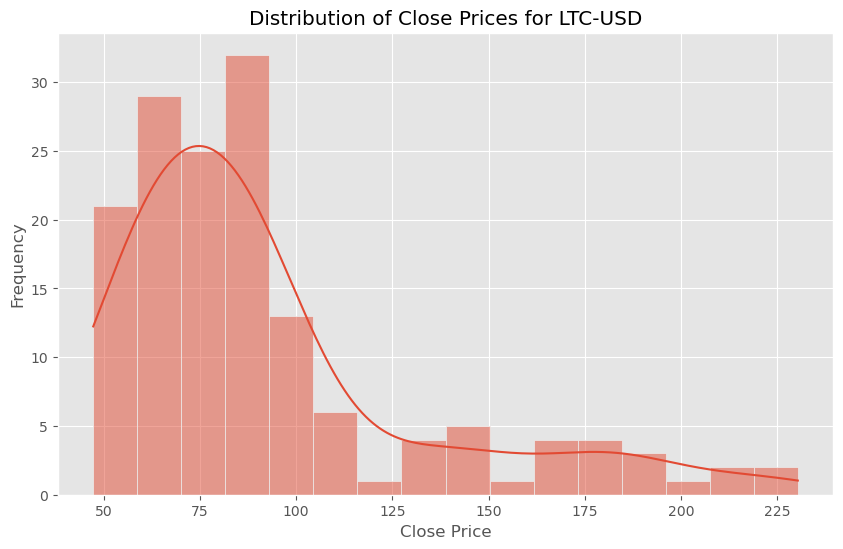

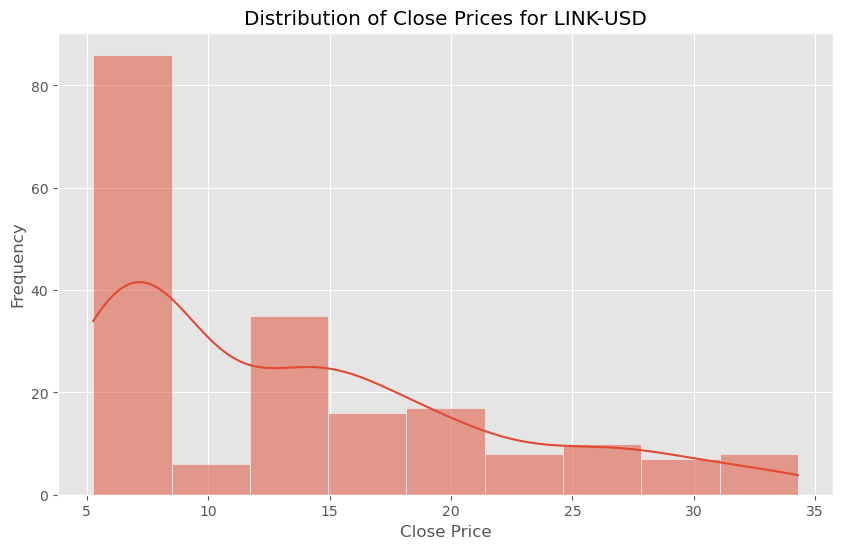

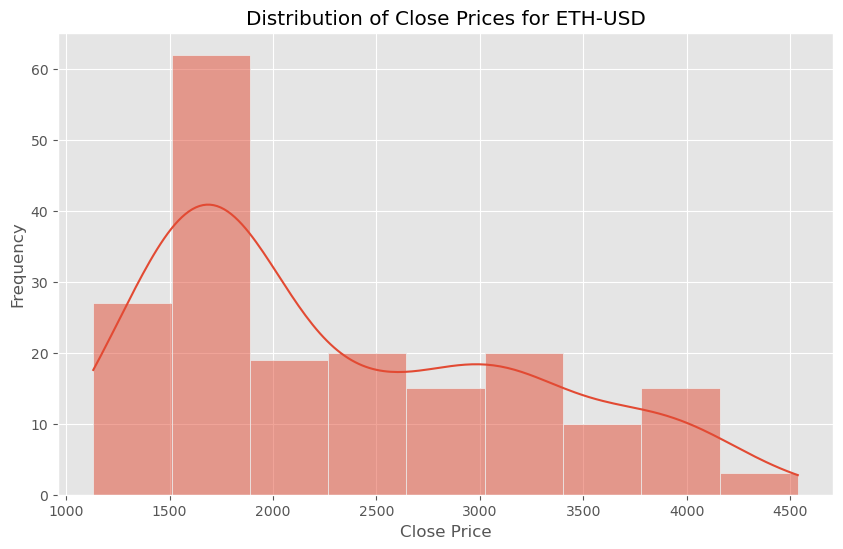

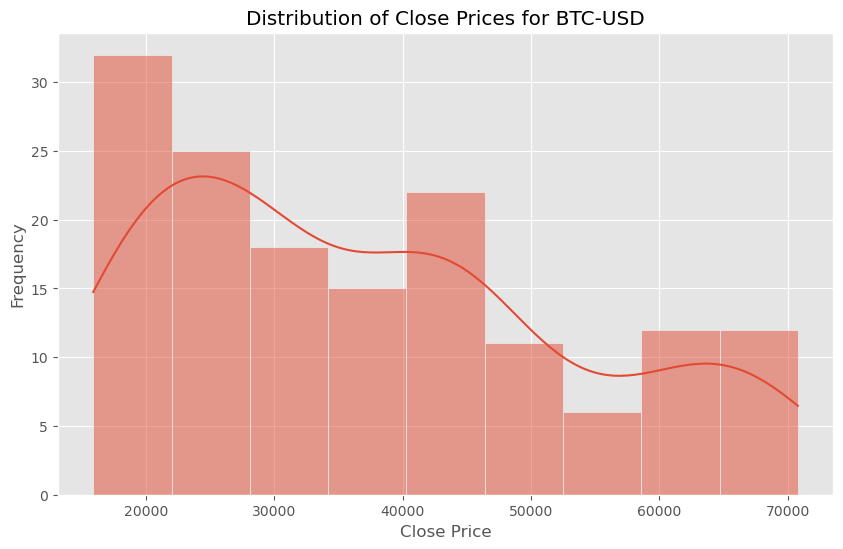

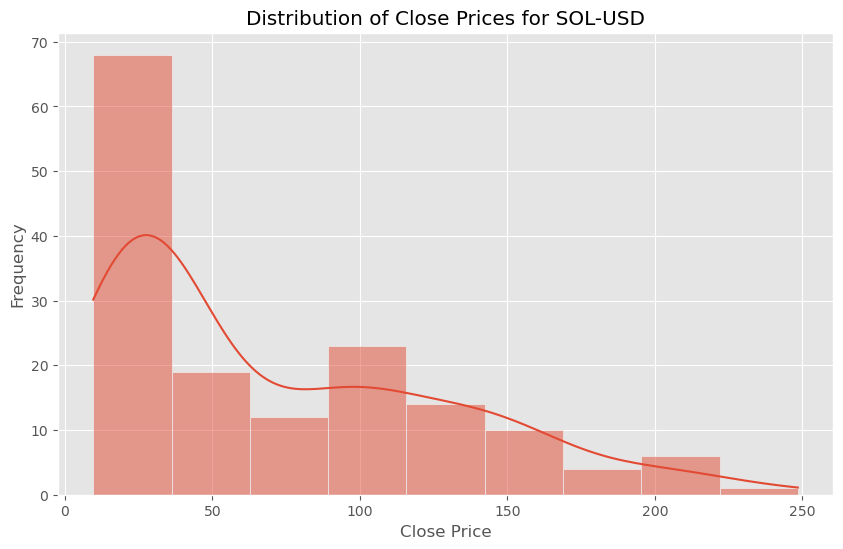

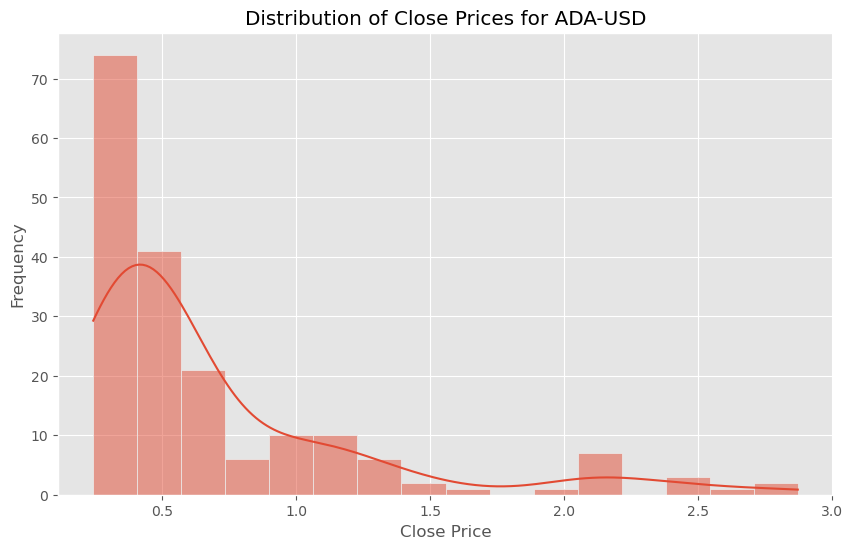

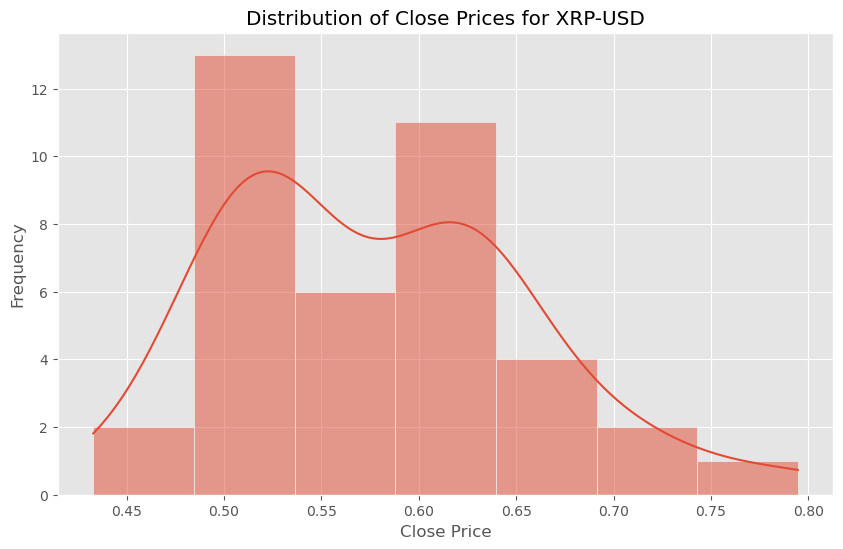

In [ ]:
# Distribution of 'close' prices per cryptocurrency
for coin in df['product_id'].unique():
    plt.figure(figsize=(10, 6))
    sns.histplot(df[df['product_id'] == coin]['close'], kde=True)
    plt.title(f'Distribution of Close Prices for {coin}')
    plt.xlabel('Close Price')
    plt.ylabel('Frequency')
    plt.show()

### Distribution of Percentage Changes for Each Cryptocurrency


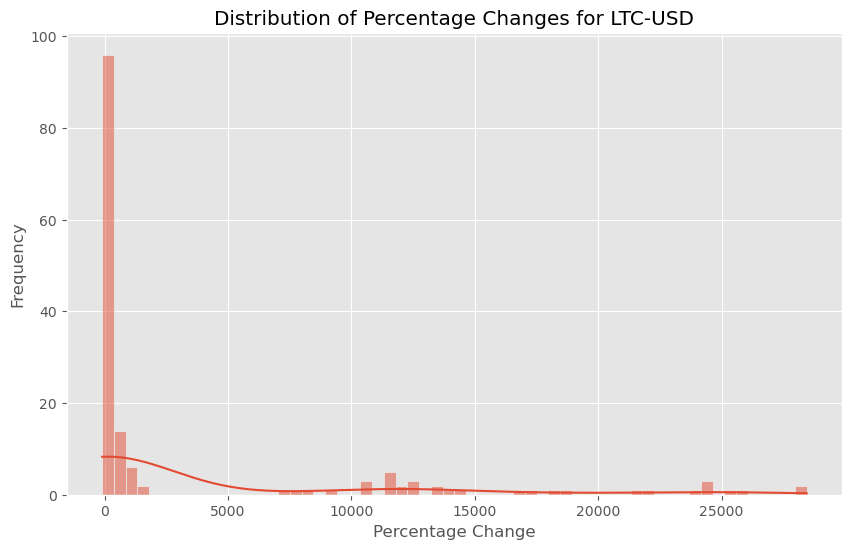

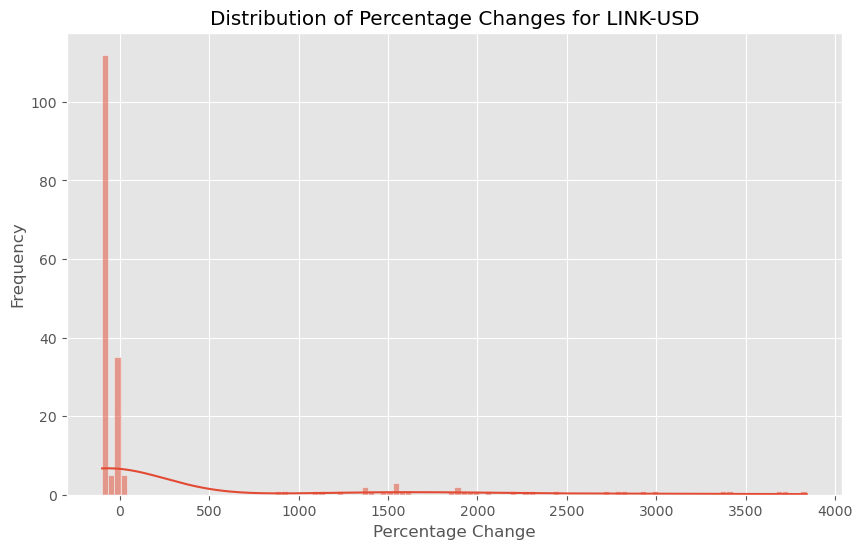

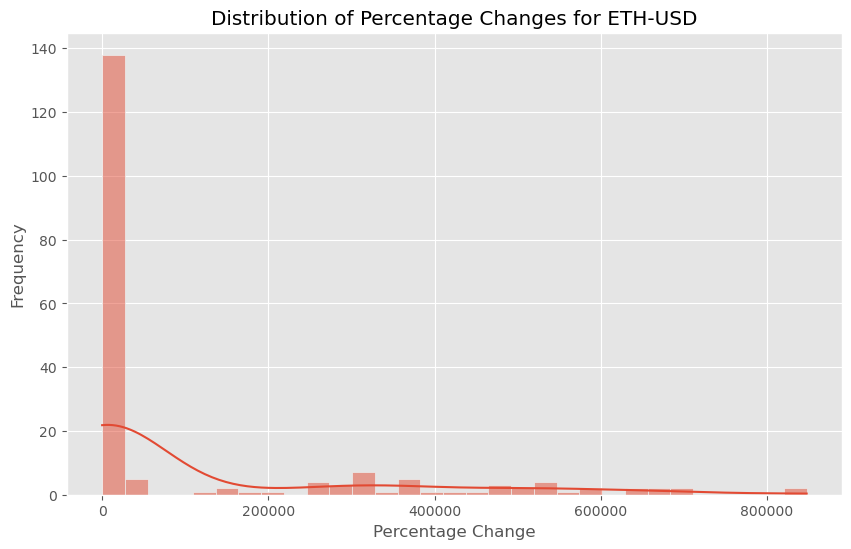

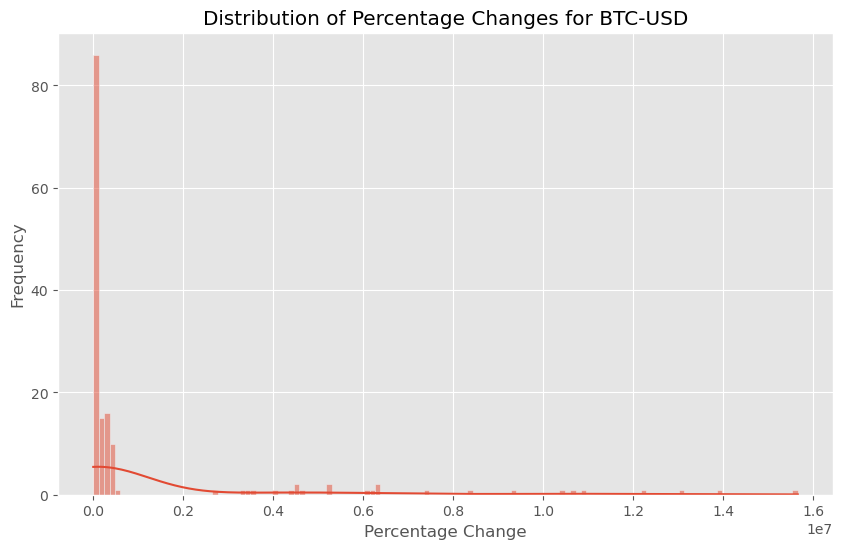

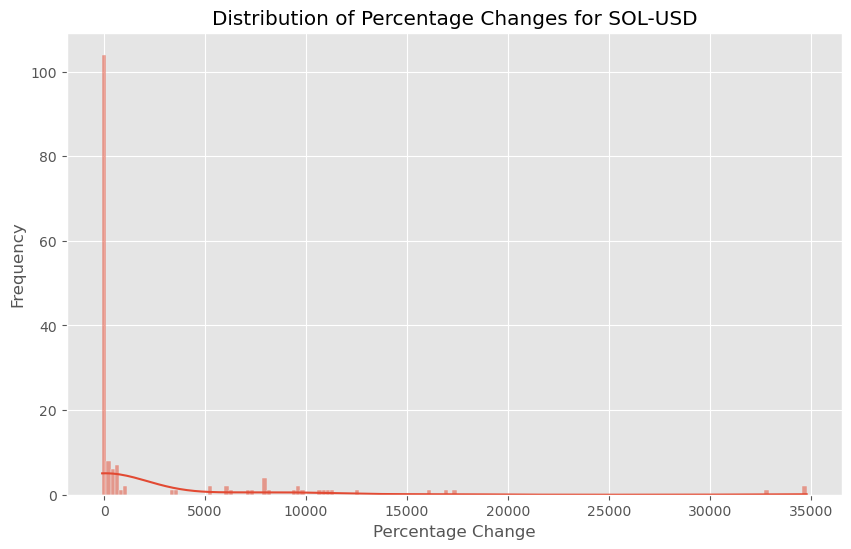

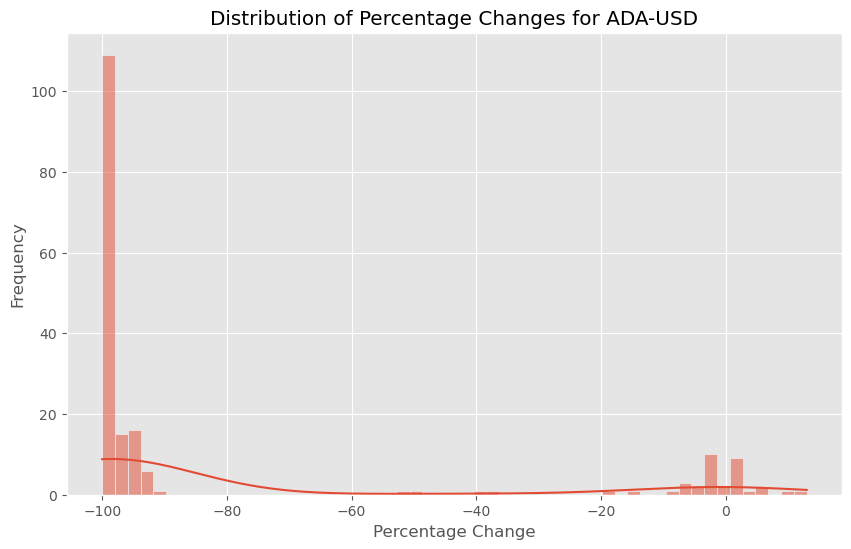

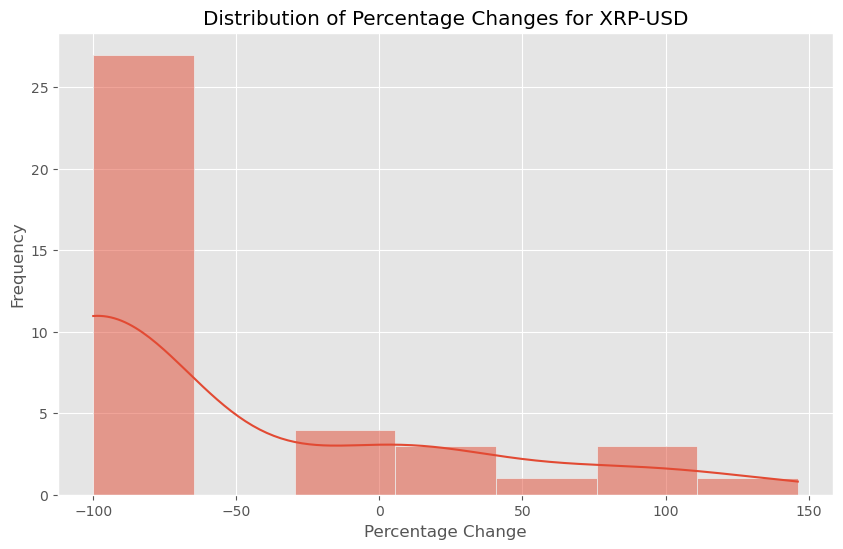

In [ ]:
# Distribution of percentage changes per cryptocurrency
for coin in df['product_id'].unique():
    plt.figure(figsize=(10, 6))
    sns.histplot(df[df['product_id'] == coin]['pct_change'].dropna(), kde=True)  # Drop NaN for initial missing value from pct_change calculation
    plt.title(f'Distribution of Percentage Changes for {coin}')
    plt.xlabel('Percentage Change')
    plt.ylabel('Frequency')
    plt.show()

### Time Series of Close Prices and Moving Average for Each Cryptocurrency

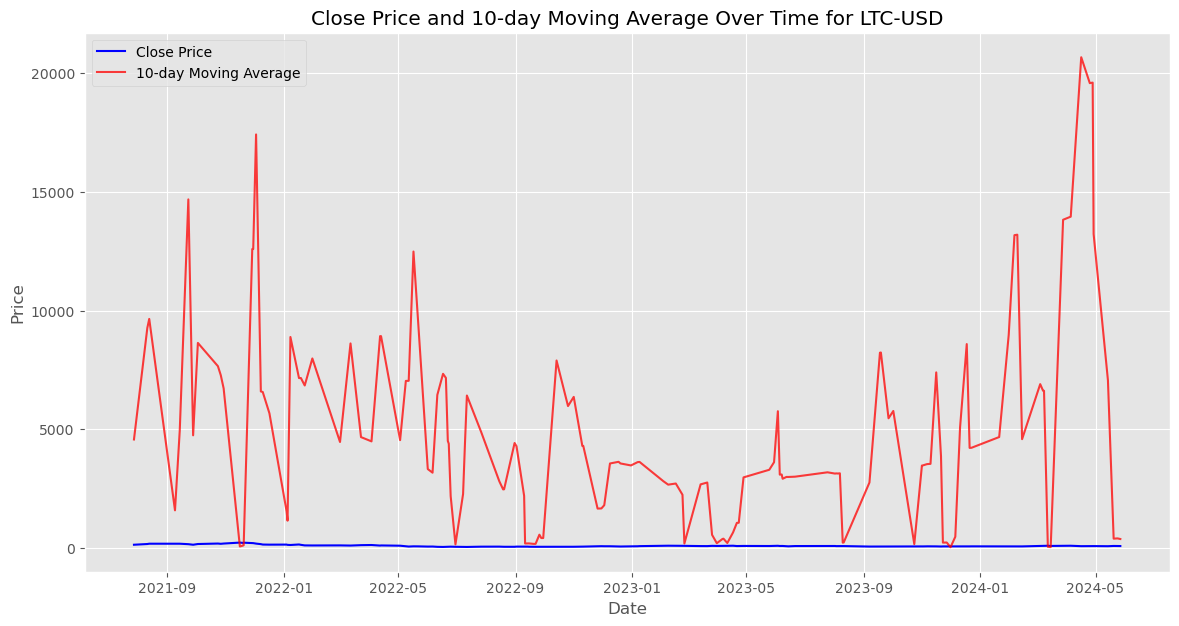

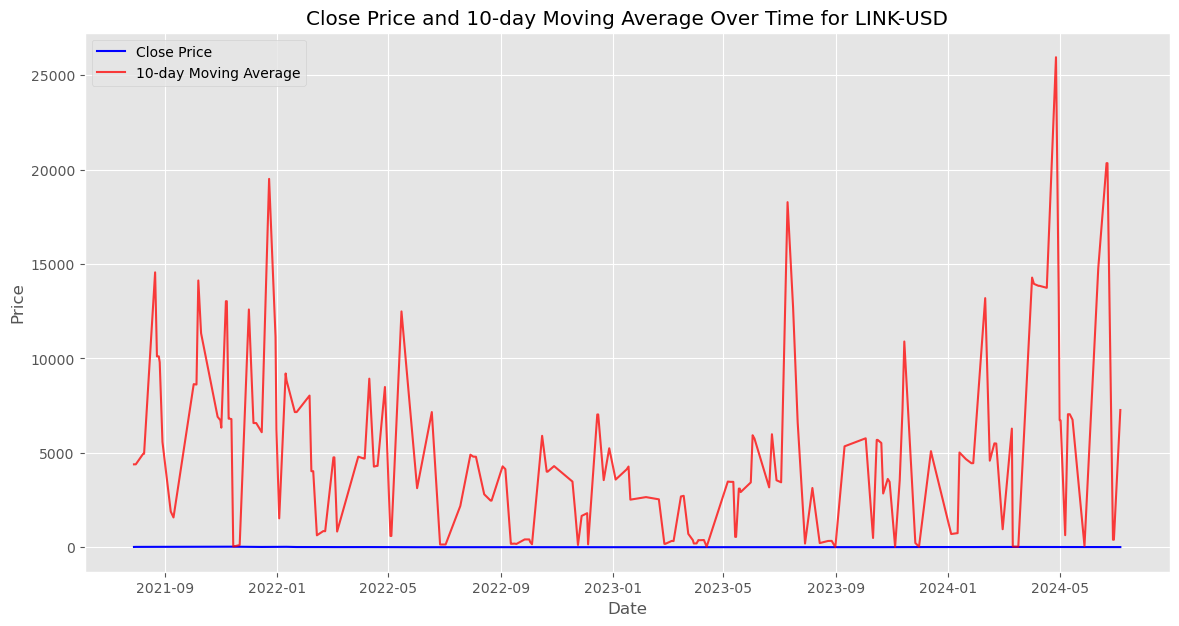

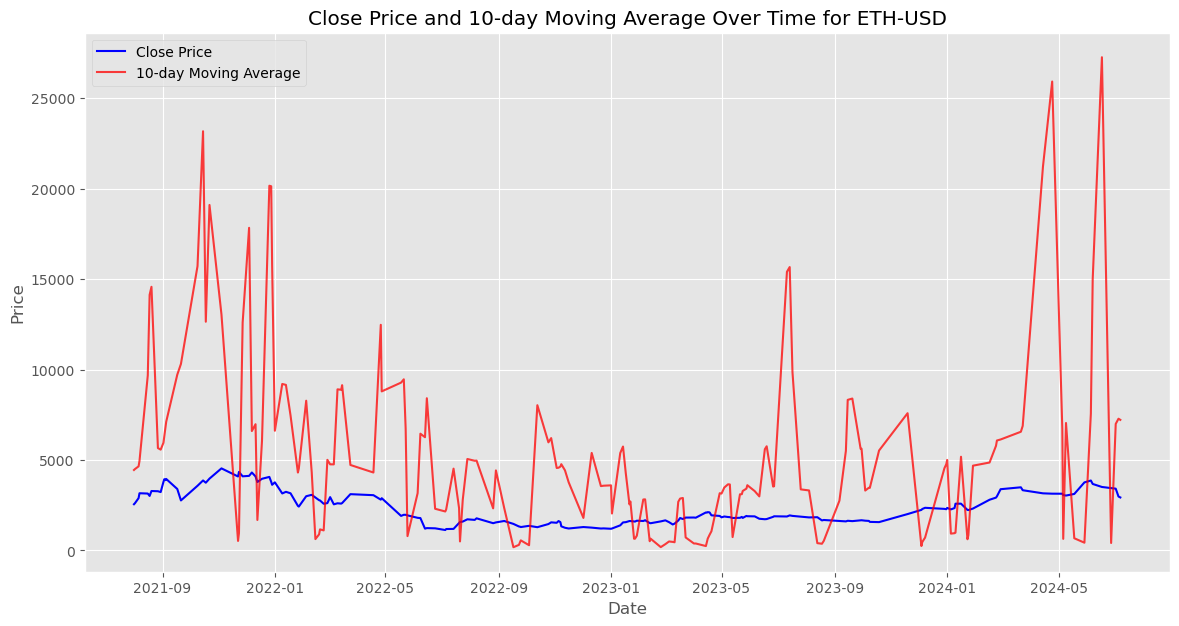

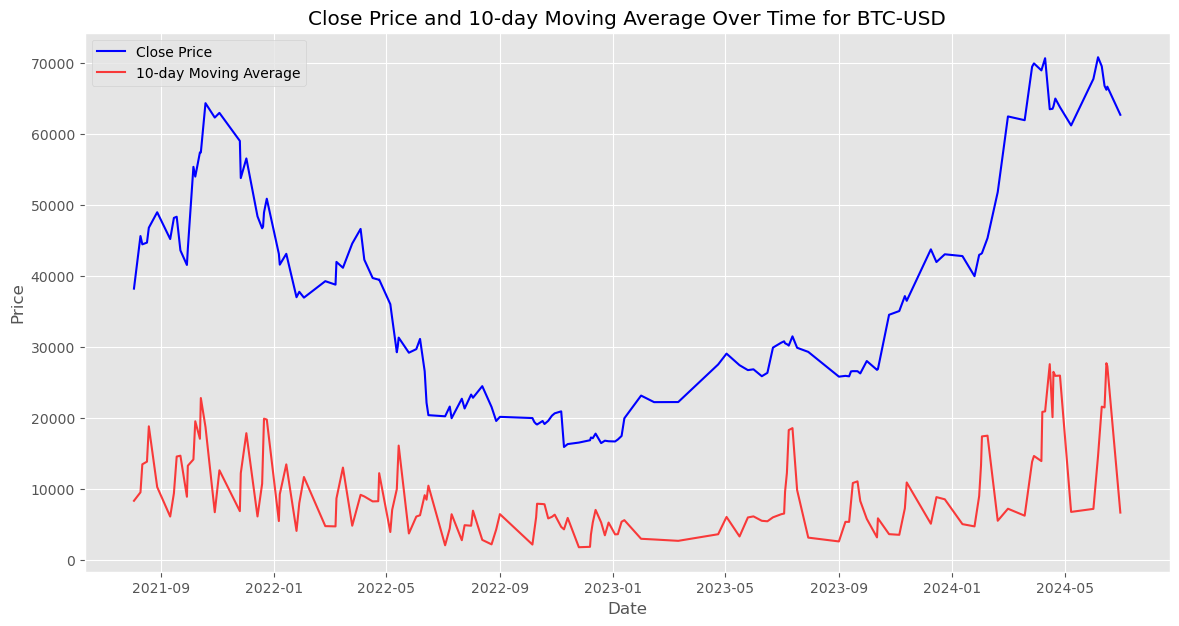

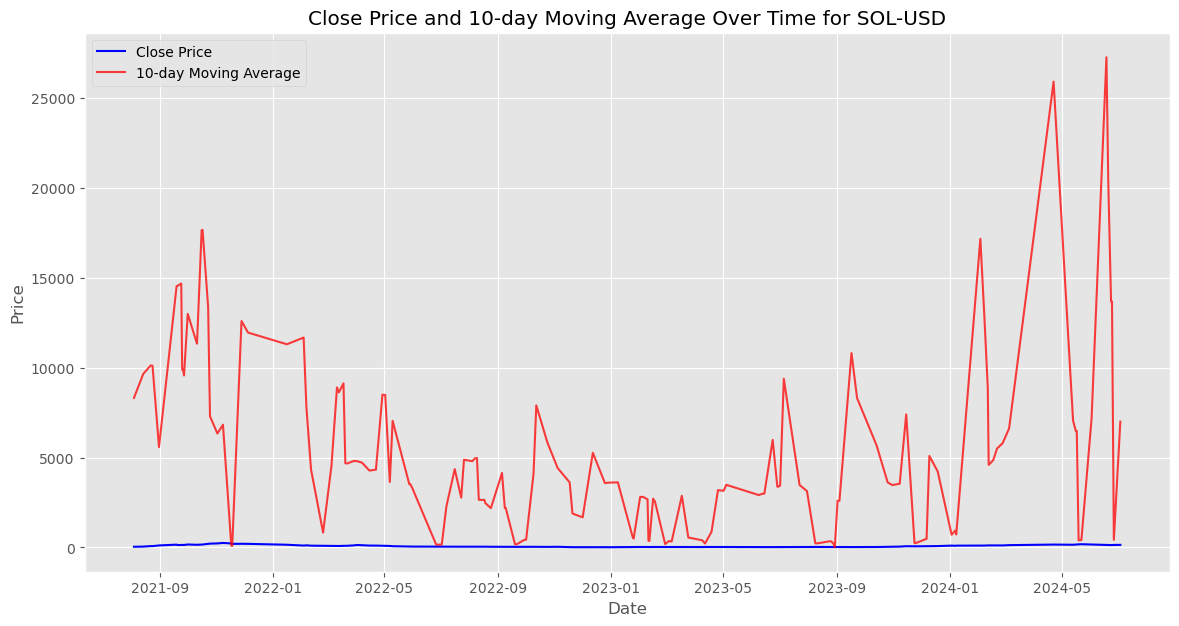

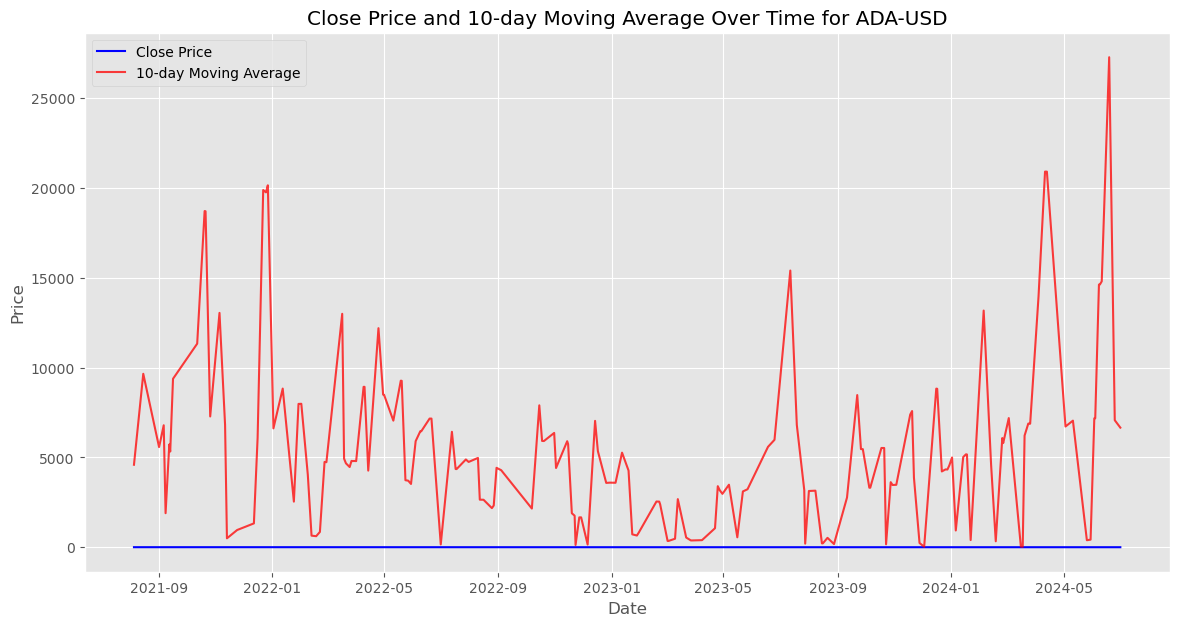

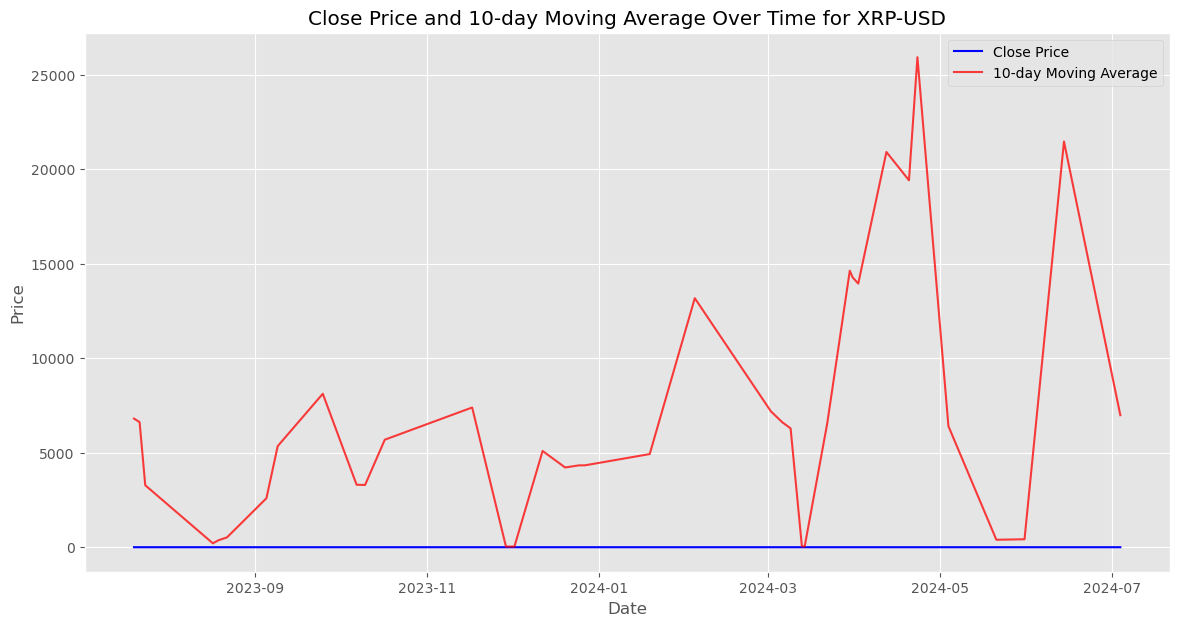

In [ ]:
# Time Series of Close Prices and Moving Average per cryptocurrency
for coin in df['product_id'].unique():
    plt.figure(figsize=(14, 7))
    coin_data = df[df['product_id'] == coin]
    plt.plot(coin_data.index, coin_data['close'], label='Close Price', color='blue')
    plt.plot(coin_data.index, coin_data['close_MA10'], label='10-day Moving Average', alpha=0.75, color='red')
    plt.title(f'Close Price and 10-day Moving Average Over Time for {coin}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

### Time Series of Percentage Changes and Moving Average for Each Cryptocurrency

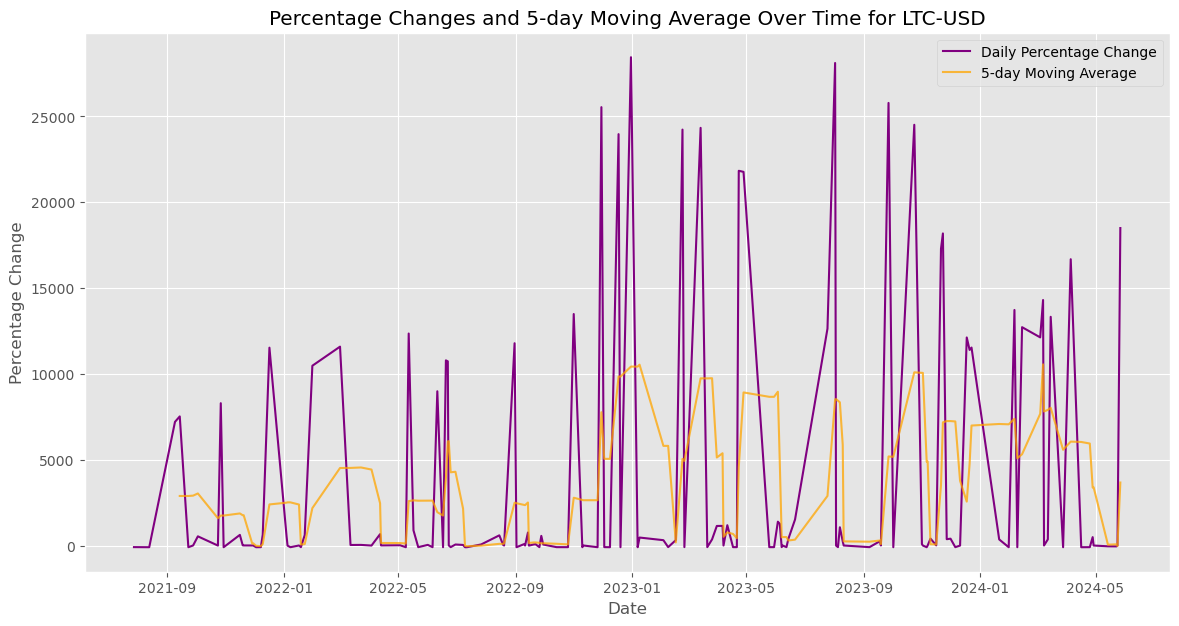

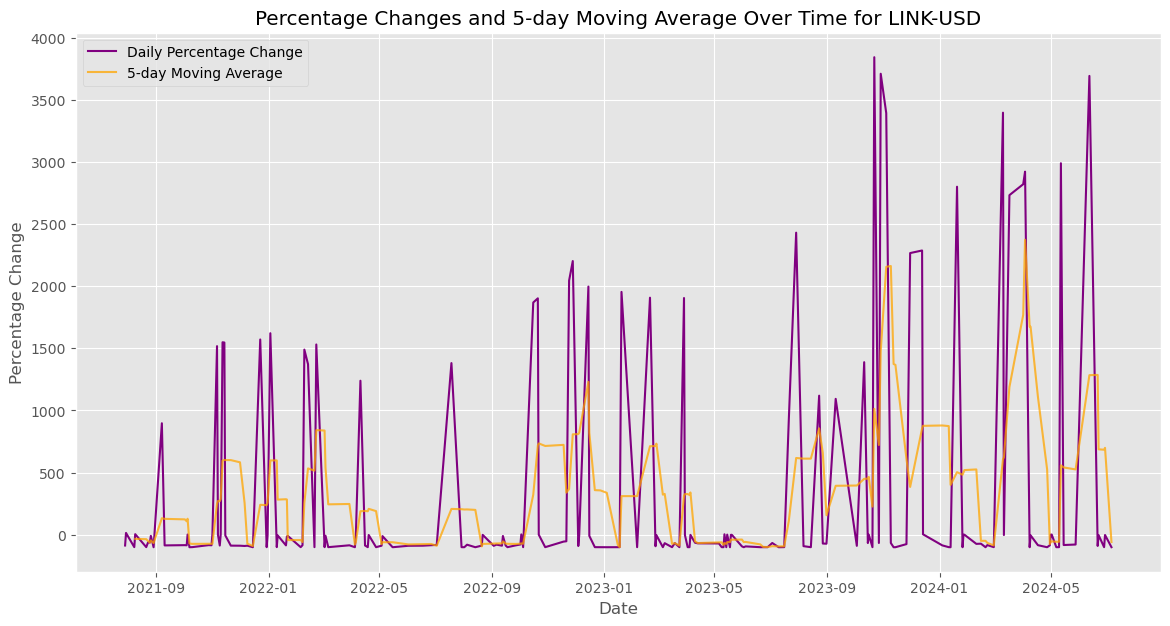

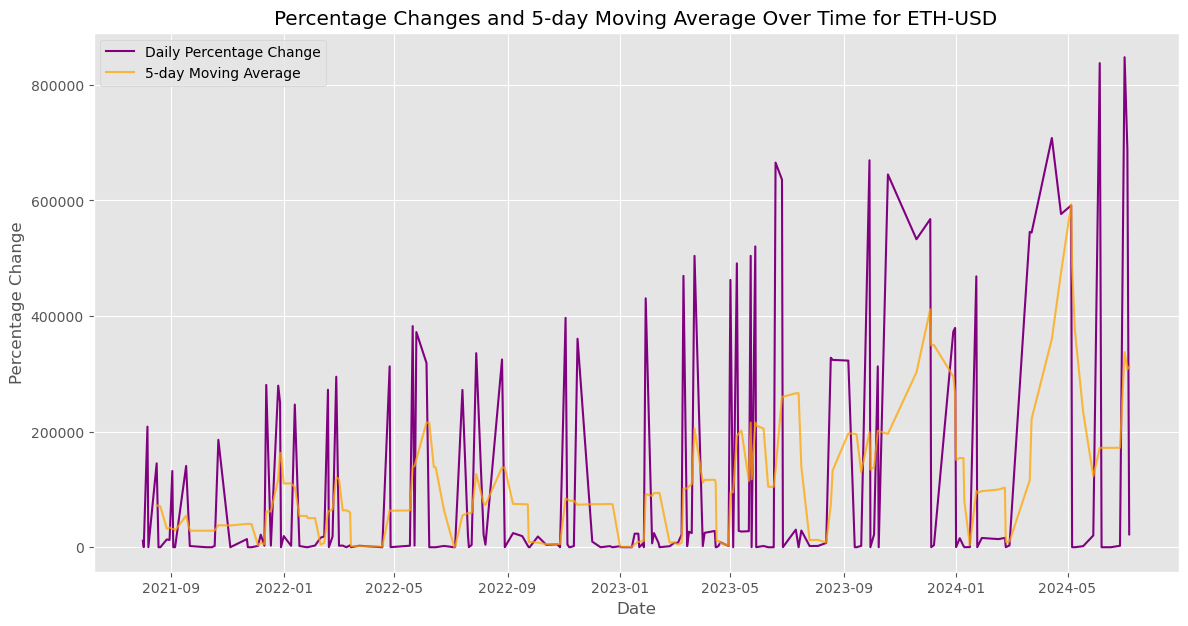

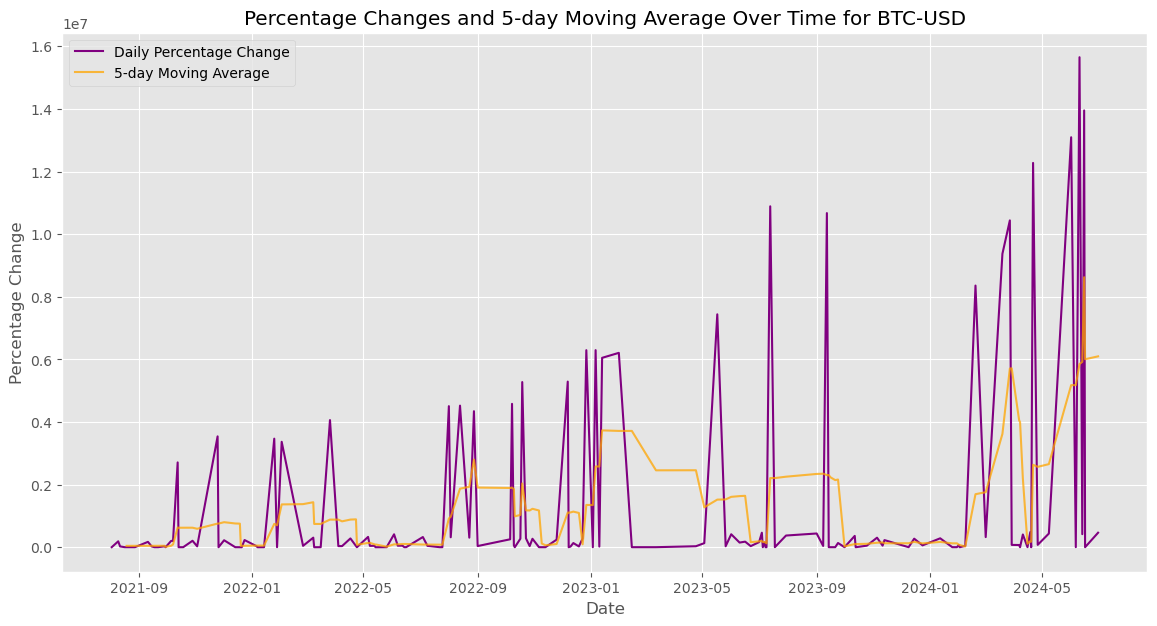

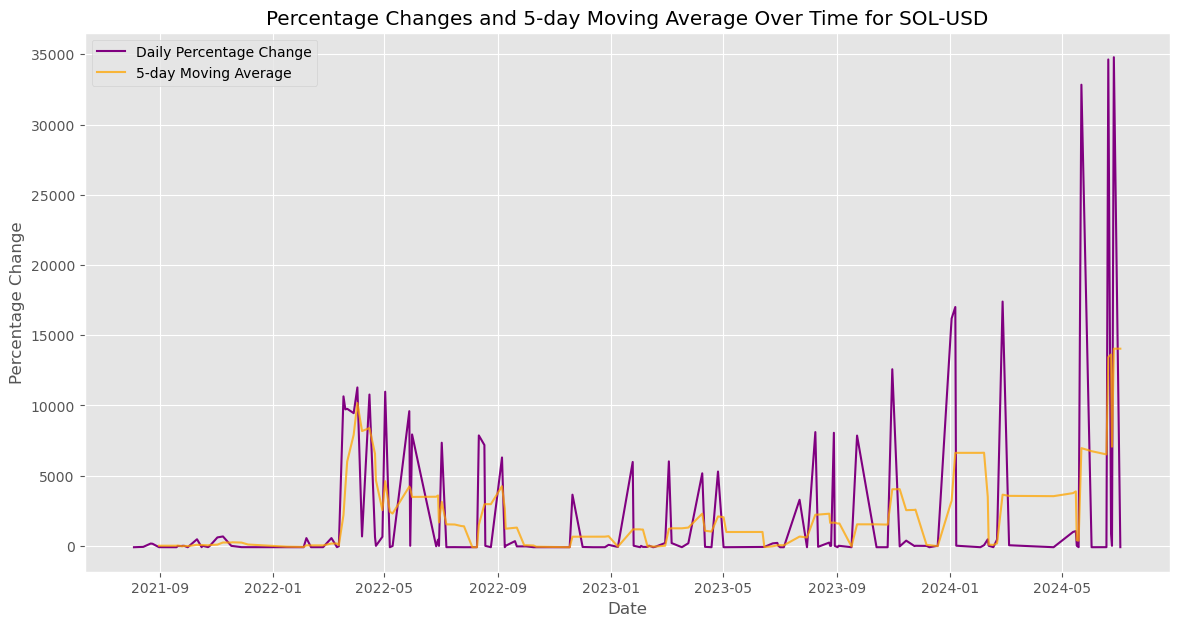

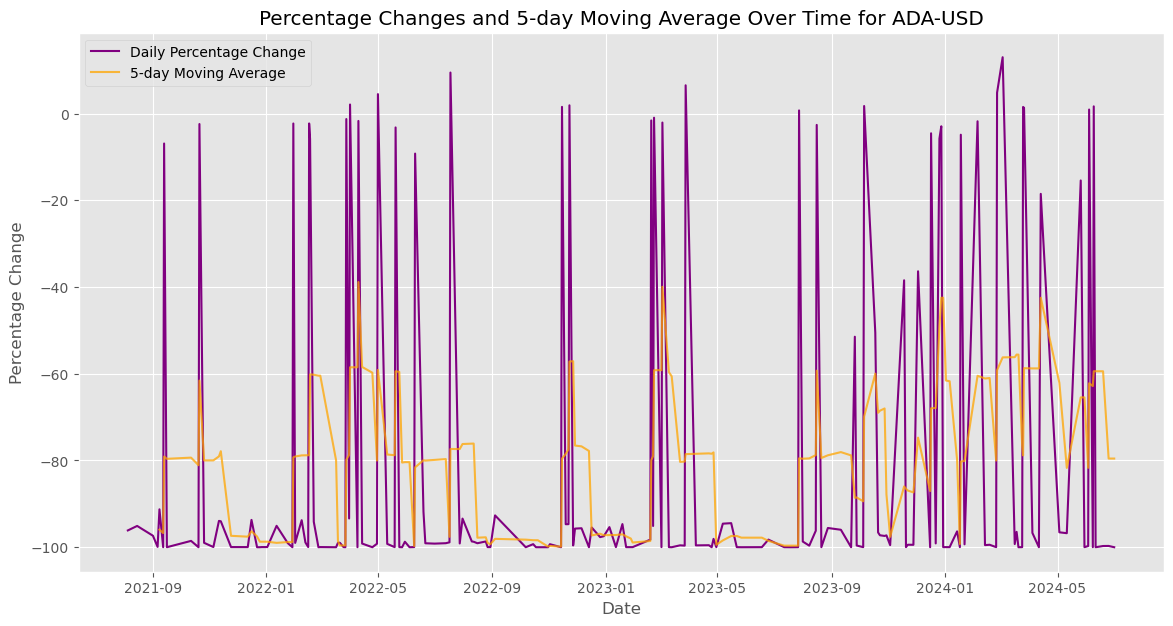

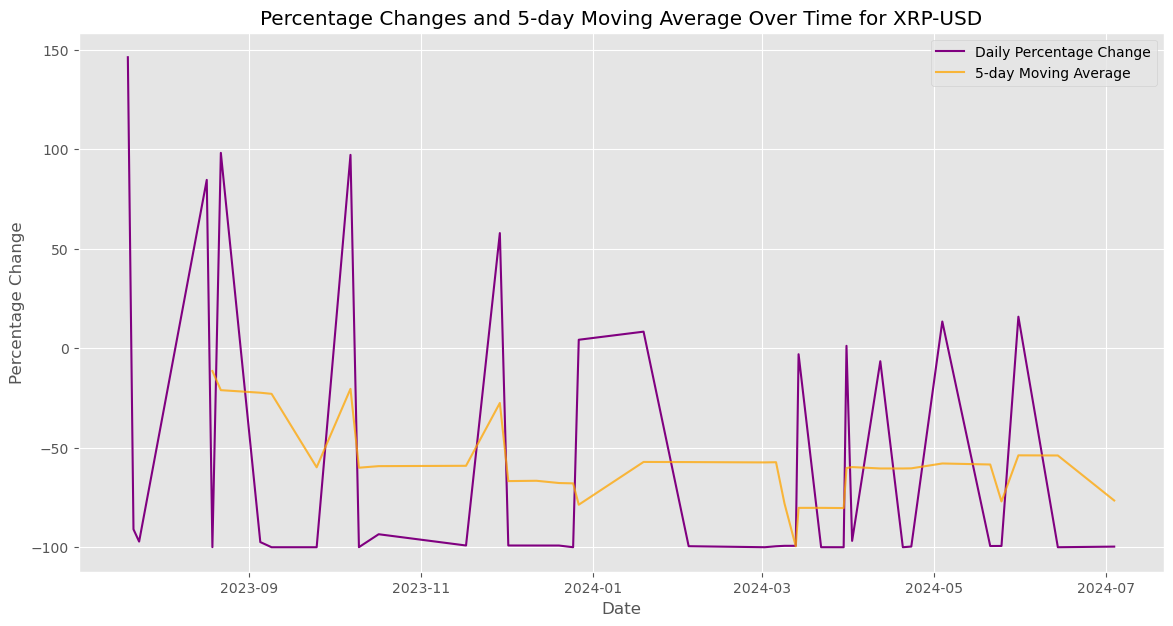

In [ ]:
# Time Series of Percentage Changes and Moving Average per cryptocurrency
for coin in df['product_id'].unique():
    plt.figure(figsize=(14, 7))
    coin_data = df[df['product_id'] == coin]
    # Calculate a moving average for percentage changes
    coin_data['pct_change_MA5'] = coin_data['pct_change'].rolling(window=5).mean()

    plt.plot(coin_data.index, coin_data['pct_change'], label='Daily Percentage Change', color='purple')
    plt.plot(coin_data.index, coin_data['pct_change_MA5'], label='5-day Moving Average', alpha=0.75, color='orange')
    plt.title(f'Percentage Changes and 5-day Moving Average Over Time for {coin}')
    plt.xlabel('Date')
    plt.ylabel('Percentage Change')
    plt.legend()
    plt.show()


### Correlation Matrix of Numeric Features for Each Cryptocurrency

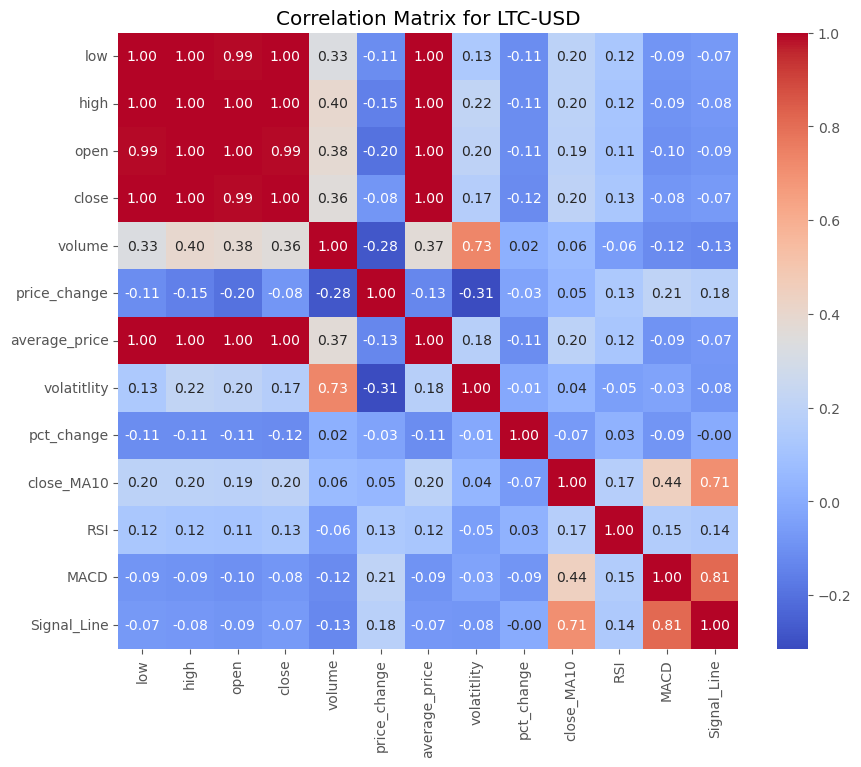

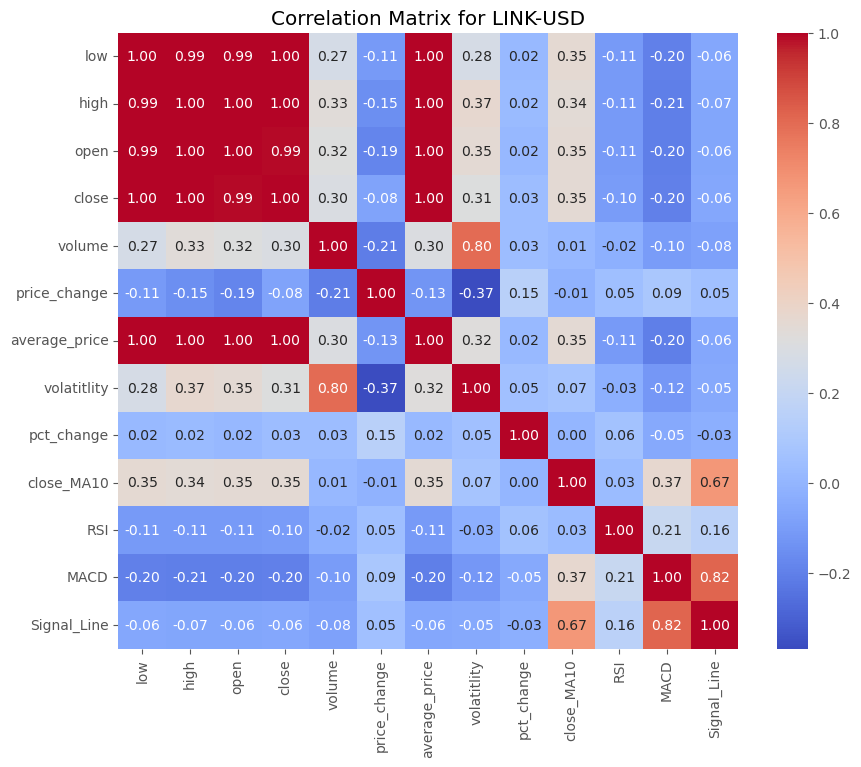

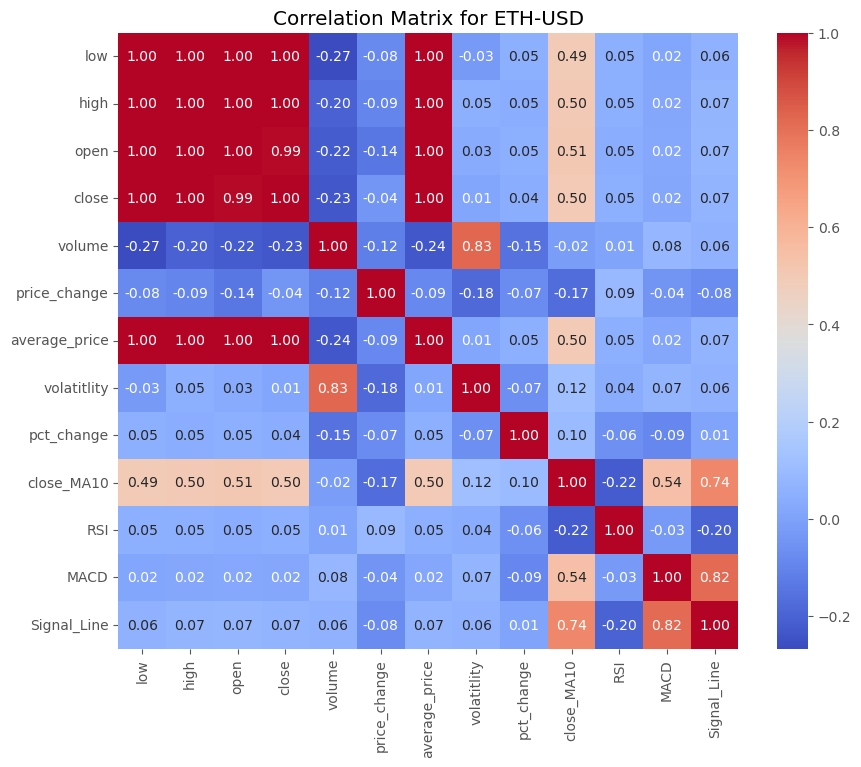

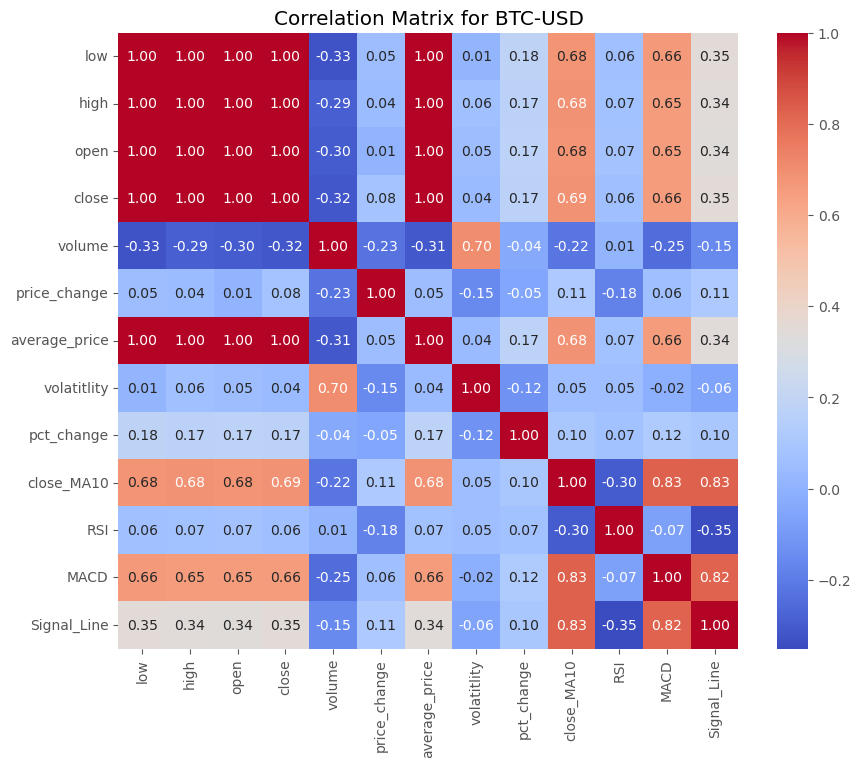

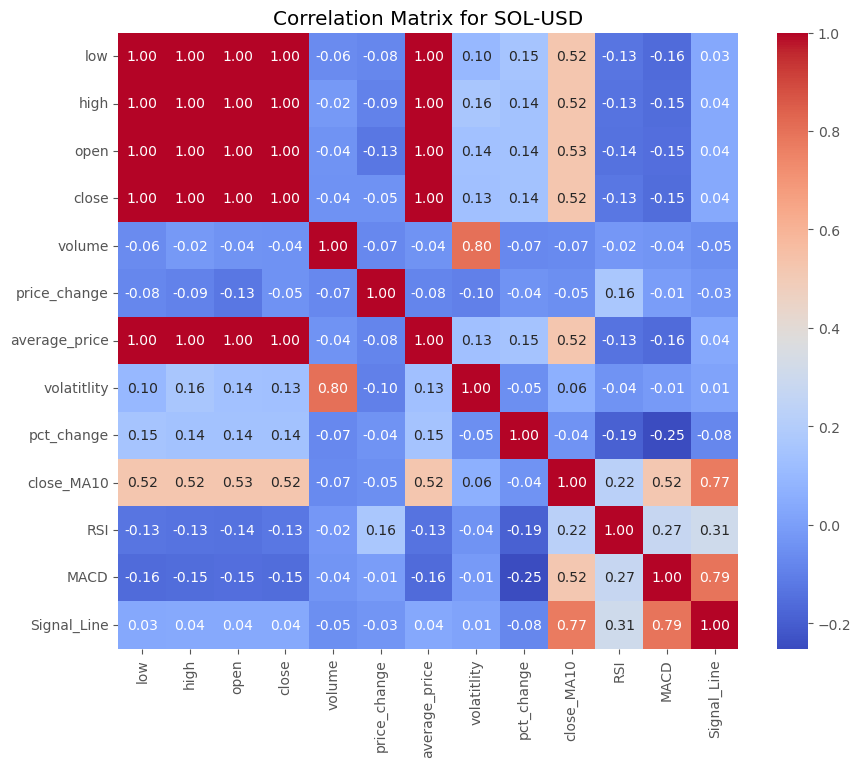

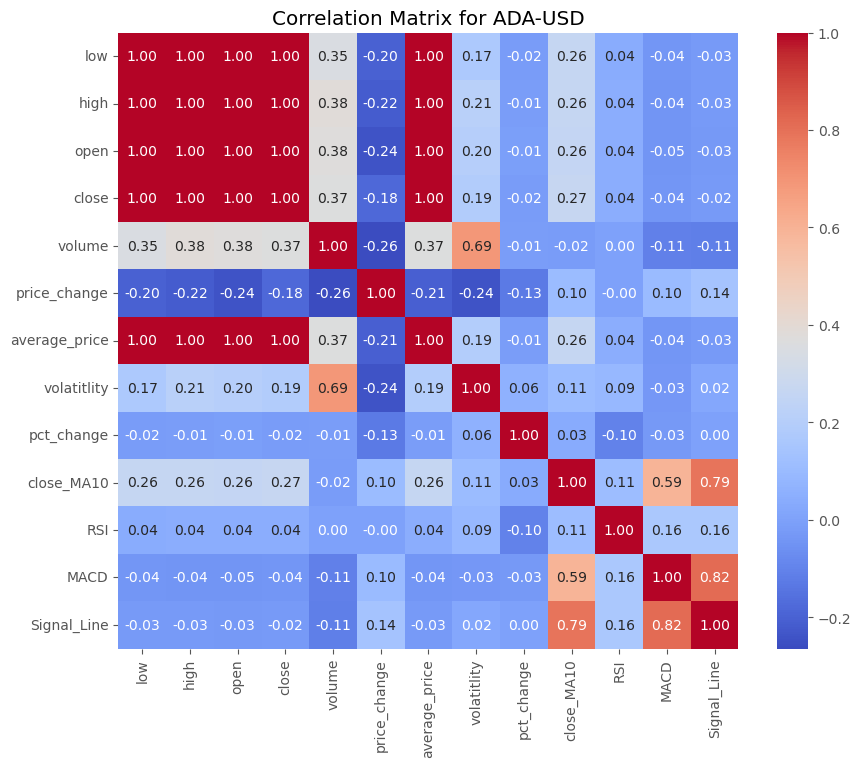

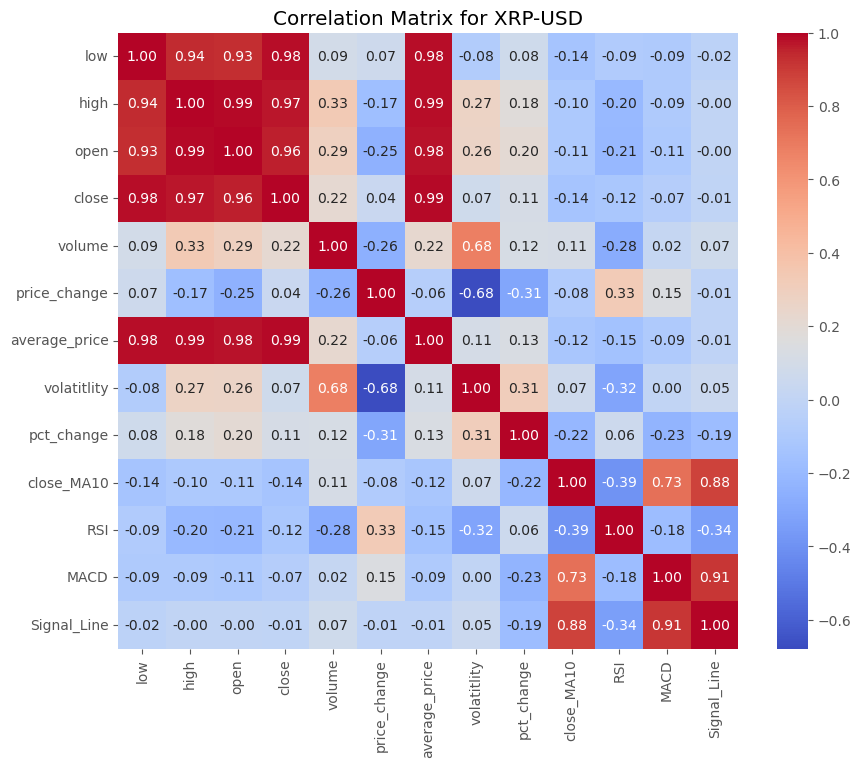

In [ ]:
# Correlation Matrix of Numeric Features per cryptocurrency
for coin in df['product_id'].unique():
    plt.figure(figsize=(10, 8))
    coin_data = df[df['product_id'] == coin].select_dtypes(include=[np.number])
    sns.heatmap(coin_data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f'Correlation Matrix for {coin}')
    plt.show()


# Pacf (partial auto correlation) look it up!!
Suggestions:
EDA:
- determine whether the data is stationary or not!(Percentage change)!
- Interpret each visual!
- look into time series techniques!

## Final Checks Before Model Development

In [ ]:
# Display final structure of the dataset and check for any anomalies
print("Final Dataset Structure:")
print(df.info())
print("\nSummary Statistics:")
print(df.describe())

# Confirm train-test split
print("\nTraining Set Preview:")
print(train.head())
print("\nTest Set Preview:")
print(test.head())


Final Dataset Structure:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1041 entries, 2021-08-27 to 2024-07-07
Data columns (total 32 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   low             1041 non-null   float64
 1   high            1041 non-null   float64
 2   open            1041 non-null   float64
 3   close           1041 non-null   float64
 4   volume          1041 non-null   float64
 5   price_change    1041 non-null   float64
 6   average_price   1041 non-null   float64
 7   volatitlity     1041 non-null   float64
 8   product_id      1041 non-null   object 
 9   pct_change      1041 non-null   float64
 10  outlier_flag    1041 non-null   bool   
 11  close_MA10      1041 non-null   float64
 12  RSI             1041 non-null   float64
 13  MACD            1041 non-null   float64
 14  Signal_Line     1041 non-null   float64
 15  close_lag_1     1041 non-null   float64
 16  volume_lag_1    1041 non-null   flo

## Model Development

In [ ]:
# Prepare the feature matrix and target vector
features = df.drop(['pct_change', 'product_id'], axis=1)  # Dropping non-numeric and target columns
target = df['pct_change']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Initialize the Lasso Regression model with an alpha value
lasso = Lasso(alpha=0.01, random_state=42)

# Fit the model to the training data
lasso.fit(X_train, y_train)

# Predict on the training and test sets
train_preds = lasso.predict(X_train)
test_preds = lasso.predict(X_test)

# Calculate and print performance metrics
train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))
train_r2 = r2_score(y_train, train_preds)
test_r2 = r2_score(y_test, test_preds)

print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training R^2: {train_r2}")
print(f"Test R^2: {test_r2}")

Training RMSE: 118.93834628739478
Test RMSE: 70.10071152447318
Training R^2: 0.9999999923884091
Test R^2: 0.9999999882268672


In [19]:
# Put in all the metrics we would wanna display on our streamlit app!
#df[['time', 'open', 'close']].to_csv('RAW_Data/test.csv')